
# Task 2

Implement a circuit that returns $\left|{01}\right\rangle$ and $\left|{10}\right\rangle$ with equal probability (50% for each).

**Requirements :**
- The circuit should consist only of **CNOT**s, **RX**s and **RY**s. 
- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 	
- You should find the right set of parameters using gradient descent (you can use more  advanced optimization methods if you like). 
- Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise. 
- Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

In [14]:
%matplotlib inline
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.aqua.components.optimizers import COBYLA, AQGD
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit import IBMQ,Aer, execute
from qiskit.providers.aer.noise import NoiseModel
import numpy as np
import matplotlib.pyplot as plt


We have to perform the following transformation:
\\[ \left|{00}\right\rangle \xrightarrow{} {1\over \sqrt{2}}\left|{01}\right\rangle + {1\over \sqrt{2}}\left|{10}\right\rangle\\]

We are limited to using only **RX**, **RY** and **Controlled NOT** gates. 

One way to do this is: 
1. Creating the superposition below by applying **RY($\theta$)** on the first qubit where $\theta = 2\times{\arcsin{1\over \sqrt{2}}}$. \\[\left|{0}\right\rangle \xrightarrow{RY(\theta)} {1\over \sqrt{2}}\left|{0}\right\rangle + {1\over \sqrt{2}}\left|{1}\right\rangle\\]. 
2. Then we apply an **X** gate to the second qubit if and only if the first qubit is in the $\ket{0}$ state. We achieve this by using the **RX($\phi$)** and **CNOT** gates in conjunction. Note that when $\phi = 2\times{\pi \over 2}$, the **RX** gate simulates a normal **X** gate.

The circuit is given below.
![Circuit](./images/circuit.png)

So we see that the optimal parameters are

- $\theta = 2 \times{\arcsin{1\over \sqrt{2}}} = 1.570796326$
- $\phi = 2\times{\pi \over 2} = 3.14159265359$

Let us use these parameters to do a sanity check for our circuit and confirm if our proposed circuit actually works.

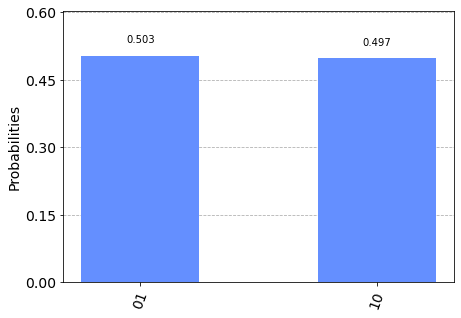

In [64]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
QuantumC = QuantumCircuit(qr,cr)
theta_fixed = np.arcsin(1/np.sqrt(2))
phi_fixed = (np.pi)/2
QuantumC.ry(2*theta_fixed, qr[0])
QuantumC.rx(2*(phi_fixed),qr[0])
QuantumC.cx(qr[0],qr[1])
QuantumC.rx(2*(phi_fixed),qr[0])
QuantumC.measure(qr,cr)
result = execute(QuantumC, Aer.get_backend('qasm_simulator')).result()
counts = result.get_counts()
plot_histogram(counts)

Also we can check out the statevector as follows:
![statevector](./images/state_vector.png)

Before we move onto the optimization part, let us create a few functions to help the code be more modular.

- We define our target distribution as a global python dictionary.
- We define a function that creates the parameterized circuit according to the current parameters.
- We define a function that puts together the output distribution as a python dictionary.
- We define a function that calculates the objective function value with the current parameters.

In [3]:
target_distr ={'10':0.5000,'01':0.5000,'11':0.0000,'00':0.0000}

In [4]:
def create_circuit(params):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    QC = QuantumCircuit(q,c)
    theta = params[0]
    phi = params[1]
    QC.ry(theta, q[0])
    QC.rx(phi,q[0])
    QC.cx(q[0],q[1])
    QC.rx(phi,q[0])
    QC.measure(q, c)
    return QC

In [5]:
def get_output_distribution(counts):
    output_distr={}
    for key in counts:
        k = key
        v = counts.get(key)/NUM_SHOTS
        output_distr.update({k:v})
    return output_distr

In [6]:
def objective_function(params):
#     print(params)
    # Obtain a quantum circuit instance from the paramters.
    qc = create_circuit(params)
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters.
    result = execute(qc, backend, shots=NUM_SHOTS).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector.
    output_distr = get_output_distribution(result.get_counts(qc))
    # Calculate the cost as the sum of squares between the output distribution and the target distribution.
    cost = 0
    key_list = ['01','10','00','11']
    # Sometimes not all of these states are present in the output distribution.
    for key in key_list:
        if key in output_distr:
            val1 = output_distr.get(key)
            val2 = target_distr.get(key)
            cost += np.power((val1 - val2),2)
        else:
            val1 = 0.0000
            val2 = target_distr.get(key)
            cost += np.power((val1 - val2),2)
    return cost

# Noiseless simulation

For noiseless simulation we are using the 'qasm_simulator' backend supplied by QISKIT.

We first use the **AQGD** optimizer to optimize the parameters. Then we use the **COBYLA** optimizer to optimize the parameters. Over 

In [7]:
backend = Aer.get_backend("qasm_simulator")

### Analytic Quantum Gradient Descent (AQGD) optimizer

In [70]:
NUM_SHOTS = 1
AQGD_distribution=[]
for num_shots in [1,10,100,1000]:
    NUM_SHOTS = num_shots
    print("Shots = %d"%(NUM_SHOTS))
    optimizer = AQGD(maxiter=1000, tol=0.0001, disp=False)

    # Choose the initial parameters randomly.
    params = np.random.rand(2)
    # params = [1.0,1.0]
    ret = optimizer.optimize(num_vars=2, objective_function=objective_function, initial_point=params)

    # Obtain the output distribution using the final parameters.
    qc = create_circuit(ret[0])
    counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
    # print(counts)
    output_distr = get_output_distribution(counts)
    AQGD_distribution.append(output_distr)
    print("Target Distribution:", target_distr)
    print("Obtained Distribution:", output_distr)
    print("Output Error:", ret[1])
    print("Parameters Found:", ret[0])
    print("-----------------------------------------------------------")

Shots = 1
Target Distribution: {'10': 0.5, '01': 0.5, '11': 0.0, '00': 0.0}
Obtained Distribution: {'01': 1.0}
Output Error: 0.5
Parameters Found: [ 0.36283016 -3.89653364]
-----------------------------------------------------------
Shots = 10
Target Distribution: {'10': 0.5, '01': 0.5, '11': 0.0, '00': 0.0}
Obtained Distribution: {'01': 0.2, '10': 0.6, '11': 0.2}
Output Error: 0.07999999999999999
Parameters Found: [0.19635197 3.71024594]
-----------------------------------------------------------
Shots = 100
Target Distribution: {'10': 0.5, '01': 0.5, '11': 0.0, '00': 0.0}
Obtained Distribution: {'10': 1.0}
Output Error: 0.147
Parameters Found: [-0.02229748  3.25264883]
-----------------------------------------------------------
Shots = 1000
Target Distribution: {'10': 0.5, '01': 0.5, '11': 0.0, '00': 0.0}
Obtained Distribution: {'01': 0.487, '10': 0.513}
Output Error: 0.0
Parameters Found: [1.54119155 3.19787894]
-----------------------------------------------------------


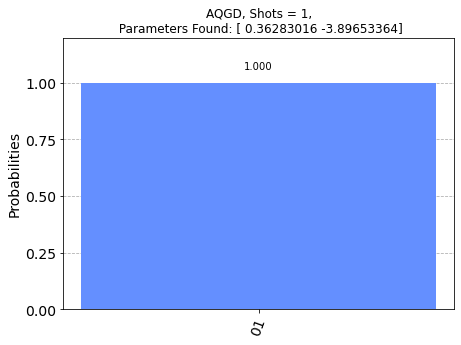

In [79]:
plot_histogram(AQGD_distribution[0], title="AQGD, Shots = 1,\n Parameters Found: [ 0.36283016 -3.89653364]")

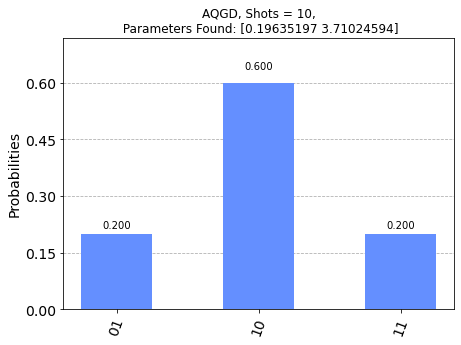

In [78]:
plot_histogram(AQGD_distribution[1], title="AQGD, Shots = 10,\n Parameters Found: [0.19635197 3.71024594]")

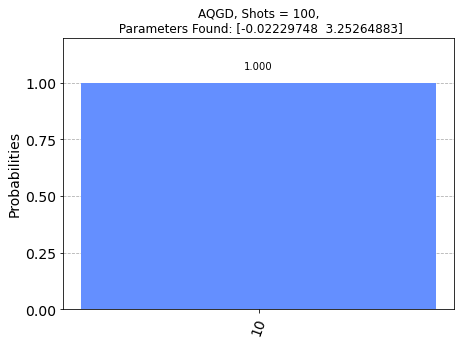

In [77]:
plot_histogram(AQGD_distribution[2], title="AQGD, Shots = 100,\n Parameters Found: [-0.02229748  3.25264883]")

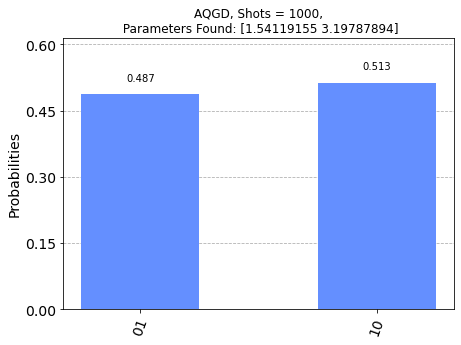

In [76]:
plot_histogram(AQGD_distribution[3], title="AQGD, Shots = 1000,\n Parameters Found: [1.54119155 3.19787894]")

### Constrained Optimization By Linear Approximation optimizer (COBYLA) Optimizer

In [51]:
NUM_SHOTS = 1
COBYLA_distribution=[]
for num_shots in [1,10,100,1000]:
    NUM_SHOTS = num_shots
    print("Shots = %d"%(NUM_SHOTS))
    optimizer = COBYLA(maxiter=1000, tol=0.0001)

    # Choose the initial parameters randomly.
    params = np.random.rand(2)
    # params = [1.0,1.0]
    ret = optimizer.optimize(num_vars=2, objective_function=objective_function, initial_point=params)

    # Obtain the output distribution using the final parameters.
    qc = create_circuit(ret[0])
    counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
    # print(counts)
    output_distr = get_output_distribution(counts)
    COBYLA_distribution.append(output_distr)
    print("Target Distribution:", target_distr)
    print("Obtained Distribution:", output_distr)
    print("Output Error:", ret[1])
    print("Parameters Found:", ret[0])
    print("-----------------------------------------------------------")
    

Shots = 1
Target Distribution: {'10': 0.5, '01': 0.5, '11': 0.0, '00': 0.0}
Obtained Distribution: {'11': 1.0}
Output Error: 0.5
Parameters Found: [0.66960754 1.78394642]
-----------------------------------------------------------
Shots = 10
Target Distribution: {'10': 0.5, '01': 0.5, '11': 0.0, '00': 0.0}
Obtained Distribution: {'01': 0.3, '10': 0.7}
Output Error: 0.01999999999999999
Parameters Found: [-1.25197199  3.04851704]
-----------------------------------------------------------
Shots = 100
Target Distribution: {'10': 0.5, '01': 0.5, '11': 0.0, '00': 0.0}
Obtained Distribution: {'01': 0.4, '10': 0.6}
Output Error: 0.0018000000000000032
Parameters Found: [1.46032738 3.2202671 ]
-----------------------------------------------------------
Shots = 1000
Target Distribution: {'10': 0.5, '01': 0.5, '11': 0.0, '00': 0.0}
Obtained Distribution: {'01': 0.505, '00': 0.006, '10': 0.485, '11': 0.004}
Output Error: 0.001074000000000002
Parameters Found: [1.61501168 2.97788816]
--------------

Let us compare the simulations for **COBYLA** optimized parameters now.

In [52]:
print(COBYLA_distribution)

[{'11': 1.0}, {'01': 0.3, '10': 0.7}, {'01': 0.4, '10': 0.6}, {'01': 0.505, '00': 0.006, '10': 0.485, '11': 0.004}]


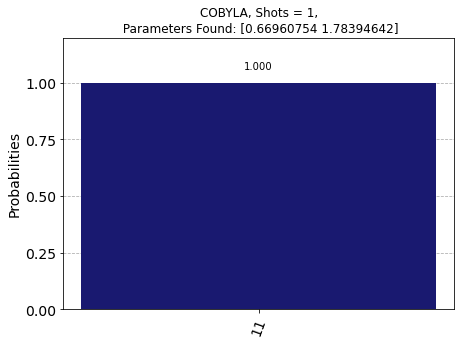

In [80]:
shots = [1, 10, 100, 1000]
plot_histogram(COBYLA_distribution[0],color='midnightblue', title="COBYLA, Shots = 1,\n Parameters Found: [0.66960754 1.78394642]")

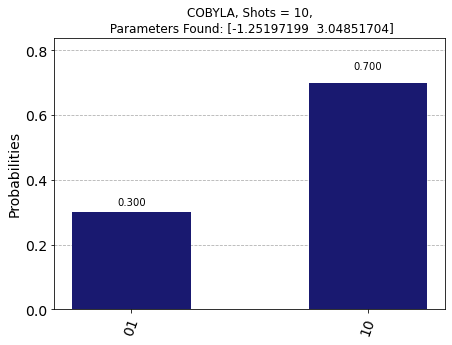

In [81]:
plot_histogram(COBYLA_distribution[1],color='midnightblue', title="COBYLA, Shots = 10,\n Parameters Found: [-1.25197199  3.04851704]")

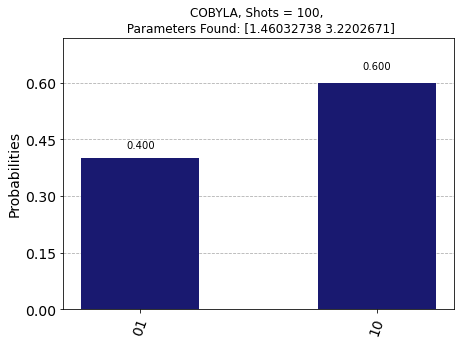

In [82]:
plot_histogram(COBYLA_distribution[2],color='midnightblue', title="COBYLA, Shots = 100, \n Parameters Found: [1.46032738 3.2202671]")

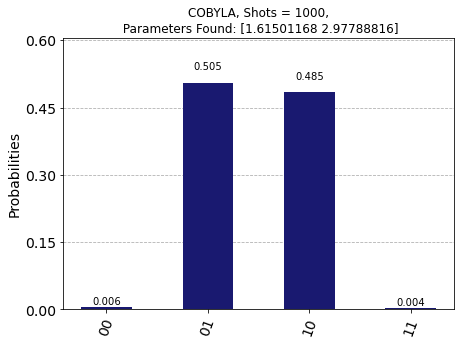

In [83]:
plot_histogram(COBYLA_distribution[3],color='midnightblue', title="COBYLA, Shots = 1000,\n Parameters Found: [1.61501168 2.97788816]")

# Simulation with Noise

We generate a noise model for our simulator from the properties of a real quantum device 'ibmq_vigo' and run the COBYLA optimizer to get the parameters for our circuit.

In [12]:
IBMQ.save_account('b0cfd5ffb53efdf98e28eb28776aa01480cdc478cddfda904805f86e585c2d93ca97998384f614b56beee907b033f92d4a2769b66dbb4438db2df363374e2544',overwrite=True)
provider=IBMQ.load_account() # Load account from disk
backend_real = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend_real)
coupling_map = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [57]:
NUM_SHOTS = 1
COBYLA_noisy_distribution=[]
for num_shots in [1,10,100,1000]:
    NUM_SHOTS = num_shots
    print("Shots = %d"%(NUM_SHOTS))
    optimizer = COBYLA(maxiter=1000, tol=0.0001)

    # Choose the initial parameters randomly.
    params = np.random.rand(2)
    # params = [1.0,1.0]
    ret = optimizer.optimize(num_vars=2, objective_function=objective_function, initial_point=params)

    # Obtain the output distribution using the final parameters.
    qc = create_circuit(ret[0])
    counts = execute(qc, Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model, shots=NUM_SHOTS).result().get_counts(qc)
    # print(counts)
    output_distr = get_output_distribution(counts)
    COBYLA_noisy_distribution.append(output_distr)

    print("Target Distribution:", target_distr)
    print("Obtained Distribution:", output_distr)
    print("Output Error:", ret[1])
    print("Parameters Found:", ret[0])
    print("-----------------------------------------------------------")

Shots = 1
Target Distribution: {'10': 0.5, '01': 0.5, '11': 0.0, '00': 0.0}
Obtained Distribution: {'01': 1.0}
Output Error: 0.5
Parameters Found: [0.50711848 0.89753926]
-----------------------------------------------------------
Shots = 10
Target Distribution: {'10': 0.5, '01': 0.5, '11': 0.0, '00': 0.0}
Obtained Distribution: {'01': 0.3, '10': 0.4, '11': 0.3}
Output Error: 0.1
Parameters Found: [-0.74355734  2.0589983 ]
-----------------------------------------------------------
Shots = 100
Target Distribution: {'10': 0.5, '01': 0.5, '11': 0.0, '00': 0.0}
Obtained Distribution: {'01': 0.54, '00': 0.02, '10': 0.43, '11': 0.01}
Output Error: 0.00020000000000000036
Parameters Found: [1.5600153  3.19630189]
-----------------------------------------------------------
Shots = 1000
Target Distribution: {'10': 0.5, '01': 0.5, '11': 0.0, '00': 0.0}
Obtained Distribution: {'01': 0.485, '00': 0.035, '10': 0.462, '11': 0.018}
Output Error: 0.002153999999999999
Parameters Found: [1.5700141  3.43

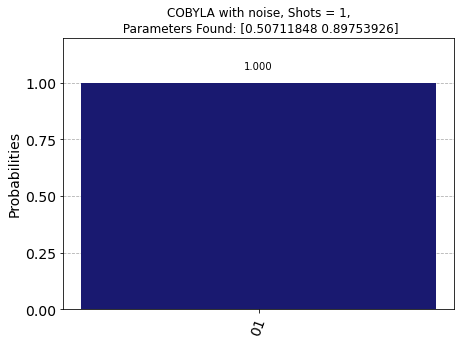

In [87]:
plot_histogram(COBYLA_noisy_distribution[0],color='midnightblue', title="COBYLA with noise, Shots = 1,\n Parameters Found: [0.50711848 0.89753926]")

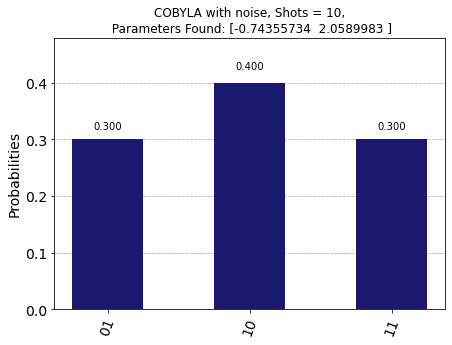

In [86]:
plot_histogram(COBYLA_noisy_distribution[1],color='midnightblue', title="COBYLA with noise, Shots = 10,\n Parameters Found: [-0.74355734  2.0589983 ]")

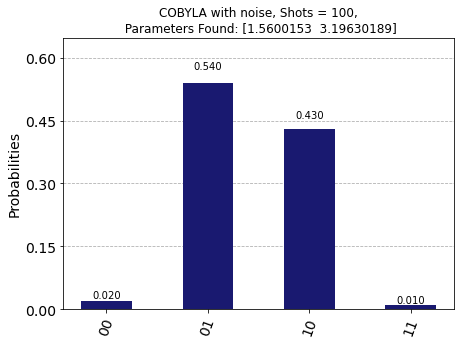

In [85]:
plot_histogram(COBYLA_noisy_distribution[2],color='midnightblue', title="COBYLA with noise, Shots = 100,\n Parameters Found: [1.5600153  3.19630189]")

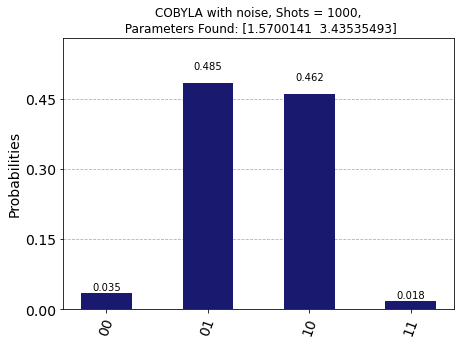

In [84]:
plot_histogram(COBYLA_noisy_distribution[3],color='midnightblue', title="COBYLA with noise, Shots = 1000,\n Parameters Found: [1.5700141  3.43535493]")

# Bonus question

### How to make sure you produce state $\left|{01}\right\rangle+\left|{10}\right\rangle$ and not $\left|{01}\right\rangle-\left|{10}\right\rangle$ ?
---
$\left|{\psi^{+}}\right\rangle={1\over \sqrt{2}}\left|{01}\right\rangle + {1\over \sqrt{2}}\left|{10}\right\rangle$ is a Bell-State. We can alternatively create this state from $\left|{01}\right\rangle$ by using the Hadamard gate and the CNOT gate as given below.
![psiplus](./images/bell_state_plus.png)
![psiplusstatevector](./images/statevector_bell_plus.png)

Similarly, $\left|{\psi^{-}}\right\rangle={1\over \sqrt{2}}\left|{01}\right\rangle - {1\over \sqrt{2}}\left|{10}\right\rangle$ is also a Bell-State. We can create this state from $\left|{11}\right\rangle$ by using the Hadamard gate and the CNOT gate as given below.
![psiminus](./images/bell_state_minus.png)
![psiminusstatevector](./images/statevector_bell_minus.png)

Hence distinguishing between these two states is as easy as applying the **CNOT** and **Hadamard** gates to our original circuit and measuring the first qubit. If it is $0$, then we have indeed produced the $\left|{\psi^{+}}\right\rangle$ state.
![measuring](./images/measuring_circuit.png)
Hence we see that we have indeed produced the desired state upto a global phase.